# Modelado
Creacion e implementacion de modelos para predecir expecativa de ol de equipos.

## Preparacion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.image as mpimg
import os

In [2]:
background_image = mpimg.imread('stadium.PNG')

In [3]:
# Importo mis funciones personalizadas
import custom_functions as cf
import custom_functions_modelado as cf_m

## Obtengo los datos ya filtrados

In [4]:
directorio_filtered = './filtered_data'

ruta_posiciones_filtered = os.path.join(directorio_filtered, 'data_posiciones_filtered.csv')
data_posiciones_filtered = pd.read_csv(ruta_posiciones_filtered)

ruta_goles_filtered = os.path.join(directorio_filtered, 'data_goles_filtered.csv')
data_goles_filtered = pd.read_csv(ruta_goles_filtered)

In [5]:
data_posiciones_filtered.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados
48814,79874,119,2,-14.466858,66.176247,104.150054,36.121799,97.383333,1,1
61201,93381,136,120,-330.726511,7.367371,22.412290,6.281770,12.316667,1,1
41952,70633,102,55,344.418394,-60.775254,-55.152822,-112.557444,190.033333,1,1
58072,89756,130,124,-72.837372,-57.912174,-272.657366,-239.916108,129.233333,1,1
28422,55333,88,81,508.492373,-34.914044,-63.191580,-17.313342,46.200000,1,1
10379,33113,55,59,454.745152,27.822147,-6.264857,5.010412,106.650000,1,1
6786,29474,50,44,-386.904756,157.792742,75.104576,35.232879,80.666667,1,1


In [6]:
data_goles_filtered.sample(7)

,id,match_id,player_id,player_name,equipo,tick
64,237,70,48,"marco!""",Blue,18.533333
139,334,110,117,Tuc,Red,12.566667
129,318,102,102,shit,Red,191.733333
162,362,122,122,respect,Blue,44.683333
131,320,103,102,shit,Red,30.266667
128,317,101,98,Orsigoat,Red,179.700000
214,421,144,137,soul ⛧ (flow br),Red,85.366667


## Etiquetado de datos
Etiqueto datos para entrenar y testear al modelo

In [7]:
# Agrupo los momentos
data_posiciones_grouped_entities = data_posiciones_filtered.groupby(['match_id', 'time']).size().reset_index(name='entities')

In [8]:
data_posiciones_grouped_filtered_labeled = data_posiciones_grouped_entities

data_posiciones_grouped_filtered_labeled['gol_1_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_2_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_3_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_4_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_5_ticks'] = 'none'
data_posiciones_grouped_filtered_labeled['gol_6_ticks'] = 'none'

In [9]:
# Diccionario para acceso rápido a los goles por match_id
goles_dict = data_goles_filtered.groupby('match_id').apply(lambda x: x[['tick', 'equipo']].to_dict('records')).to_dict()

In [10]:
# Iterar sobre las filas de data_grouped_entities_7ents
for index, row in data_posiciones_grouped_filtered_labeled.iterrows():
    match_id = row['match_id']
    time = row['time']
    
    if match_id in goles_dict:
        goles = goles_dict[match_id]
        
        # Filtrar goles futuros a partir del tiempo actual
        futuros_goles = [gol for gol in goles if gol['tick'] > time]
        
        for offset in range(1, 7):  # Revisar para ticks 1, 2, 3, 4, 5 y 6
            gol_cercano = next((gol['equipo'] for gol in futuros_goles if gol['tick'] <= time + offset), 'none')
            col_name = f'gol_{offset}_ticks'
            data_posiciones_grouped_filtered_labeled.at[index, col_name] = gol_cercano

In [11]:
match_id_test = 141
data_posiciones_grouped_filtered_labeled_idtest = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['match_id'] == match_id_test]

# Configuro para que se muestren todas las filas y columnas
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.expand_frame_repr', False)  # Evita que las columnas se corten

data_posiciones_grouped_filtered_labeled_idtest.sample(7)

,match_id,time,entities,gol_1_ticks,gol_2_ticks,gol_3_ticks,gol_4_ticks,gol_5_ticks,gol_6_ticks
9282,141,61.6,7,none,none,none,none,none,none
9229,141,8.6,7,none,none,none,none,none,none
9270,141,49.6,7,none,none,none,none,none,none
9289,141,68.6,7,Red,Red,Red,Red,Red,Red
9233,141,12.6,7,none,none,none,none,none,none
9258,141,37.6,7,none,none,none,none,none,none
9252,141,31.6,7,none,none,none,none,none,none


In [12]:
# Configuro para que vuelva a los valores estandar de las filas y columnas
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')

## Resumen de los datos de entrenamiento
Hasta aqui existen 3 tablas que seran utiles:
* data_posiciones_filtered: datos filtrados de las posiciones de todos los jugadores en todas las instacias de todos los partidos.
* data_goles_filtered: datos de todos los goles de todos los partidos que pasaron el filtrado.
* data_posiciones_grouped_filtered_labeled: datos de las tuplas 'match_id' - 'time' de los momentos registrados que pasaron el filtrados, etiquetados en 6 columnas que indican si va a haber un gol (y de que equipo) dentro de 'n' ticks. 

## Normalizacion

In [13]:
ejemplo_crudo = [
-469.33245391540754,	-76.99622069143119,	-98.22601789631604,	-6.999637312526858, 1,
-245.8619738989556,	-75.90666882766646,	-157.8397101075912,	-16.180327951704218, 2, 
-183.74626114265607,	-173.07488268564356,	-127.13862497611889,	-67.44588004849875, 1, 
-153.9710503428658,	-169.40925561404282,	-104.16354380853112,	-10.323911873561645, 2, 
202.3357095430081,	-9.972215052858196,	-158.92286262264113,	3.943821709944109, 2, 
-196.1001185928374,	138.84749567600224,	-93.26727433047343,	-35.91405742771945, 1, 
-187.30970981132464, -200.66362383270027,	-120.68753894299226,	-5.273878455600128, 0
]

columns = ['x', 'y', 'velocity_x', 'velocity_y', 'team']
data_test1 = pd.DataFrame([ejemplo_crudo[i:i + 5] for i in range(0, len(ejemplo_crudo), 5)], columns=columns)

data_test1_normalizada = cf.normalizar_datos(data_test1)
print(data_test1_normalizada)

          x         y  velocity_x  velocity_y  team
0  0.000000  0.364251    0.924473    0.846708    -1
1  0.332710  0.367461    0.016497    0.718109     1
2  0.425189  0.081260    0.484106    0.000000    -1
3  0.469520  0.092057    0.834039    0.800143     1
4  1.000000  0.561665    0.000000    1.000000     1
5  0.406797  1.000000    1.000000    0.441686    -1
6  0.419884  0.000000    0.582362    0.870882     0


In [14]:
from sklearn.preprocessing import MinMaxScaler

data_posiciones_filtered_original = data_posiciones_filtered.copy() # Me guardo una copia del dataframe sin normalizar
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered_original['match_time'] = data_posiciones_filtered_original['match_id'].astype(str) + '_' + data_posiciones_filtered_original['time'].astype(str)

columns_to_normalize = ['x', 'y', 'velocity_x', 'velocity_y']

scaler = MinMaxScaler()
data_posiciones_filtered_normalized = data_posiciones_filtered
data_posiciones_filtered_normalized[columns_to_normalize] = scaler.fit_transform(data_posiciones_filtered[columns_to_normalize])
data_posiciones_filtered_normalized['team'] = data_posiciones_filtered_normalized['team'].map({1: -1, 2: 1, 0: 0})

In [15]:
data_posiciones_filtered_normalized.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados
26495,51247,77,63,0.806768,0.952808,0.166961,0.669604,184.583333,-1,1
16614,41234,67,70,0.287765,0.178410,0.176854,0.596502,28.150000,1,1
11536,34270,58,2,0.641697,0.715278,0.174900,0.719384,51.116667,-1,1
32422,60788,92,93,0.473928,0.345278,0.157666,0.628008,223.033333,1,1
62120,94300,136,2,0.531667,0.785793,0.213226,0.625576,143.316667,-1,1
41209,69890,102,107,0.609652,0.876926,0.196955,0.649879,84.033333,-1,1
58352,90435,132,120,0.633807,0.235908,0.194468,0.649624,10.650000,1,1


In [16]:
data_posiciones_filtered_original.sample(7)

,id,match_id,player_id,x,y,velocity_x,velocity_y,time,team,cant_de_duplicados,match_time
27409,52161,79,72,353.391699,-126.298077,45.626095,15.630230,94.583333,1,1,79_94.58333333332924
6433,29121,50,2,236.900405,135.035045,-64.424496,-6.917635,30.666667,2,1,50_30.66666666666621
64186,96677,140,134,352.459207,-75.473812,164.017988,2.064682,128.850000,2,1,140_128.84999999999468
16461,41081,67,67,-183.035462,102.388691,-158.167939,13.793275,6.150000,2,1,67_6.149999999999984
47264,77969,116,2,-127.079849,158.545593,-100.287029,42.839923,131.150000,2,1,116_131.1499999999965
37554,66201,98,0,256.217878,0.398867,61.521228,-103.143511,17.783333,0,1,98_17.783333333333605
50889,82069,122,0,21.684915,29.621969,174.906950,130.025451,9.100000,0,1,122_9.100000000000032


## Modelos (esta parte se encuentra en desarrollo)

### Primer modelo: Red Neuronal 001
Caracteristicas y parametros:
* MLPClassifier
    * alpha=0.001
    * hidden_layer_sizes=(256, 128, 64)
    * learning_rate_init=0.001
    * ctivation='relu'
    * solver='adam'
    * max_iter=500
    * random_state=900438094)
* Funcion en custom_functions_modelado:
    * modelar_red_neuronal_001(
        random_state,
        background_image,
        data_posiciones_grouped_filtered_labeled,
        data_posiciones_filtered,
        data_posiciones_filtered_original,
        gol_n_ticks
        )

#### Para 4 ticks

##### Modelo principal
Se incluye:
* El armado del modelo (red neuronal)
* Analisis de prediccion de probabilidades en momentos tomados al azar
* Analisis del momento del partido (grafico de la cancha) con las probabilidades predichas por el modelo

In [17]:
random_state = 900438094


Algunas datos de X:
 [[ 0.56072537  0.21041758  0.15494614  0.63350013 -1.          0.45156856
   0.13582412  0.15927311  0.6159887  -1.          0.27707426  0.39052766
   0.16970158  0.58481902 -1.          0.78550743  0.47752242  0.15902889
   0.67273744  1.          0.49351683  0.42534334  0.16122105  0.65201908
   1.          0.5090093   0.17127178  0.15921935  0.63499244  1.
   0.27784403  0.22211606  0.13139727  0.70288768  0.        ]
 [ 0.2825912   0.42663018  0.18344802  0.6285137   1.          0.46447642
   0.44233171  0.18319211  0.63340374  1.          0.2107438   0.5
   0.18399394  0.62584773 -1.          0.27996381  0.36197083  0.18309648
   0.62791721 -1.          0.44017897  0.4540382   0.19220087  0.59307485
  -1.          0.51239669  0.81542756  0.18399394  0.62584773  1.
   0.42194968  0.08380815  0.17547479  0.48716827  0.        ]]

Algunos datos de y:
 ['none' 'Blue']

Distribución balanceada de clases:
 Counter({'none': 798, 'Blue': 399, 'Red': 399})

Algunos in

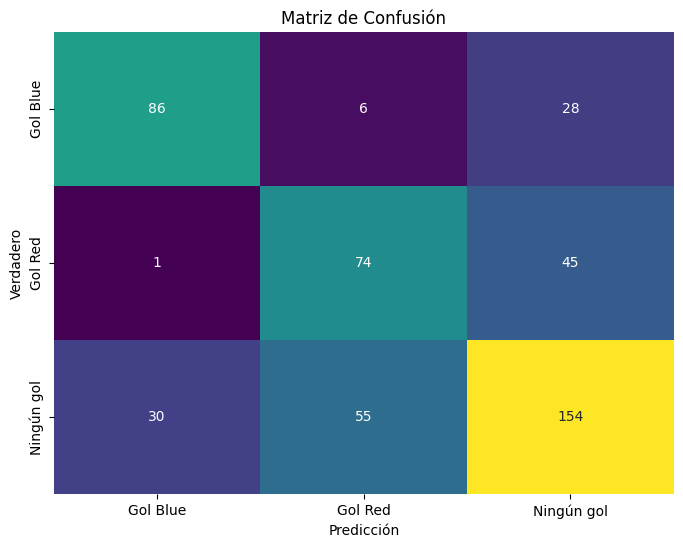


GRAFICO DE DISTRIBUCION DE PROBABILIDAD DE CLASES DE 10 MOMENTOS AL AZAR:


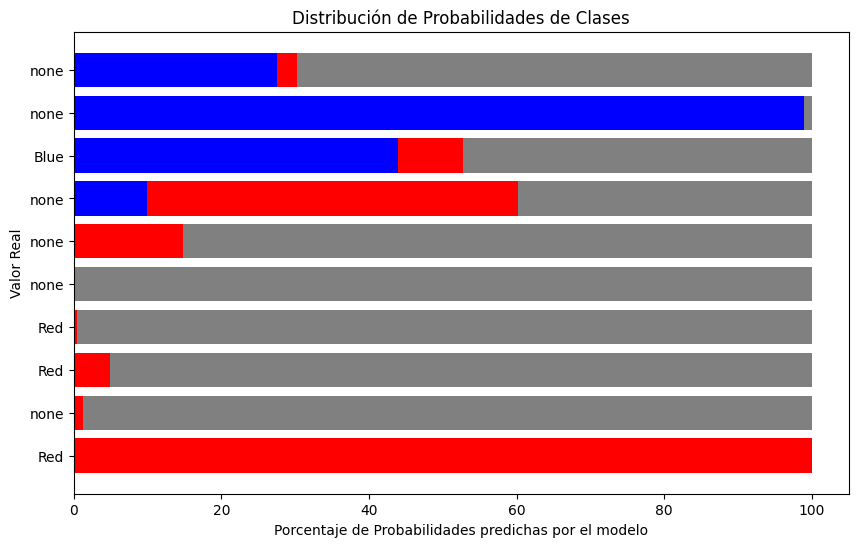


GRAFICO DE 10 MOMENTOS AL AZAR Y LAS PREDICCIONES DEL MODELO:


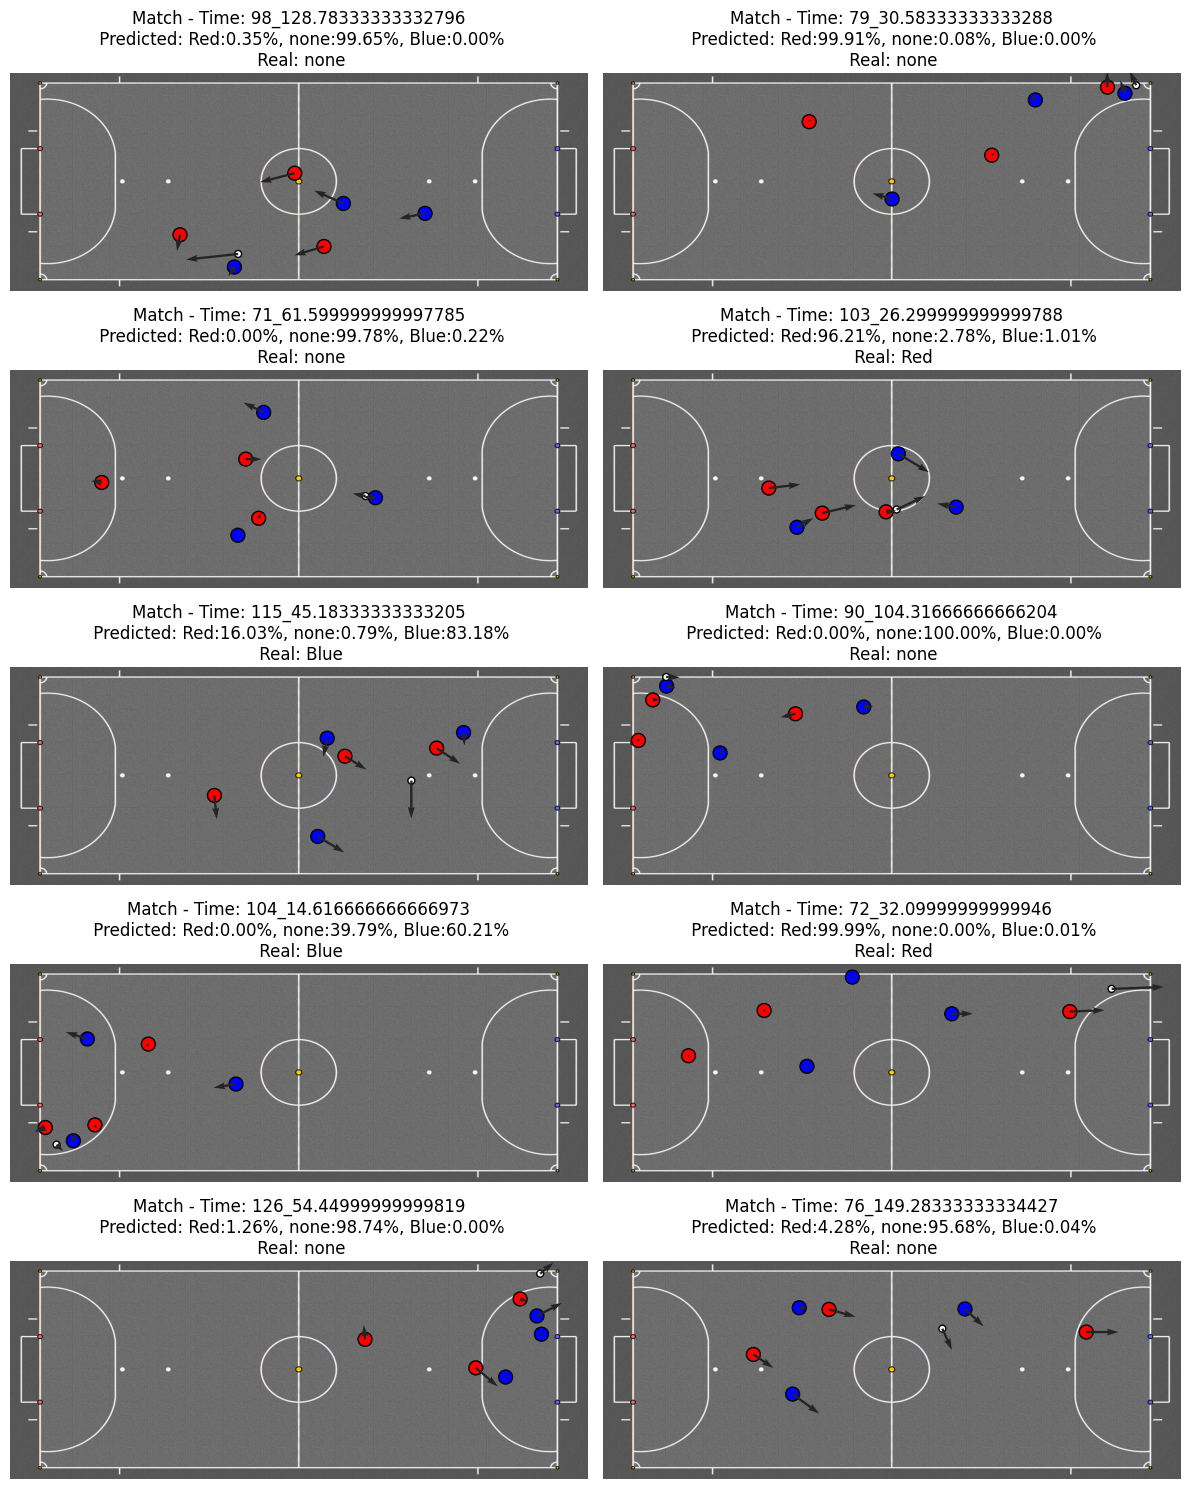

In [18]:
cf_m.modelar_red_neuronal_001(
    random_state,
    background_image,
    data_posiciones_grouped_filtered_labeled,
    data_posiciones_filtered,
    data_posiciones_filtered_original,
    'gol_4_ticks'
    )

##### GridSearchCV + Cross Validation (en desarrollo)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Ejecutar la validación cruzada con 5 pliegues
scores = cross_val_score(modelo, X, y, cv=5)

# Mostrar las puntuaciones para cada pliegue
print("Puntuaciones por pliegue:", scores)

# Promedio de las puntuaciones
print("Puntuación media de la validación cruzada:", scores.mean())

In [27]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a probar
param_grid = {
    #'hidden_layer_sizes': [(128, 64, 32), (64, 32), (128, 128), (256, 128, 64)],
    'hidden_layer_sizes': [(128, 64, 32), (64, 32), (128, 128)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01]
}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(MLPClassifier(max_iter=500, random_state=random_state), param_grid, cv=5)

# Ajustar el modelo con los datos
grid_search.fit(X, y)

# Ver los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Ver la mejor puntuación obtenida
print("Mejor puntuación:", grid_search.best_score_)

C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge

Mejores parámetros: {'alpha': 0.001, 'hidden_layer_sizes': (128, 128), 'learning_rate_init': 0.01}
Mejor puntuación: 0.7136461598746082


In [28]:
# Hacer predicciones con el mejor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluar el modelo con el conjunto de prueba
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Reporte de clasificación:
               precision    recall  f1-score   support

        Blue       0.95      0.98      0.97       120
         Red       0.93      0.88      0.90       120
        none       0.93      0.94      0.94       239

    accuracy                           0.94       479
   macro avg       0.94      0.93      0.93       479
weighted avg       0.94      0.94      0.93       479



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Ejecutar la validación cruzada con 5 pliegues
scores = cross_val_score(best_model, X, y, cv=5)

# Mostrar las puntuaciones para cada pliegue
print("Puntuaciones por pliegue:", scores)

# Promedio de las puntuaciones
print("Puntuación media de la validación cruzada:", scores.mean())

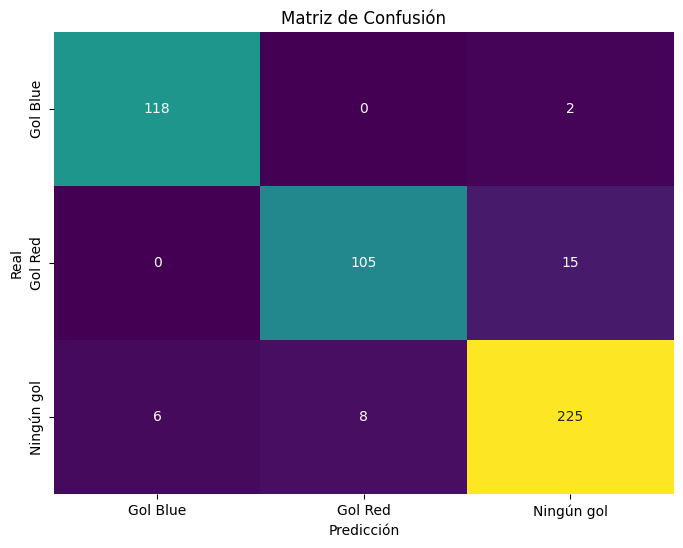

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'],
            yticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [31]:
indices_y_test = y_test.index
match_id_time_test = data_posiciones_filtered.loc[indices_y_test,]
match_id_time_test

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [31]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a probar
param_grid = {
    #'hidden_layer_sizes': [(128, 64, 32), (64, 32), (128, 128), (256, 128, 64)],
    'hidden_layer_sizes': [(128, 64, 32), (64, 32), (64, 32, 16)],
    'alpha': [0.1, 1, 10],
    'learning_rate_init': [0.001, 0.01]
}

# Configurar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(MLPClassifier(max_iter=500, random_state=random_state), param_grid, cv=5, scoring='f1_weighted')

# Ajustar el modelo con los datos
grid_search.fit(X, y)

# Ver los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Ver la mejor puntuación obtenida
print("Mejor puntuación:", grid_search.best_score_)

Mejores parámetros: {'alpha': 0.1, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001}
Mejor puntuación: 0.7029008706163224


In [32]:
# Hacer predicciones con el mejor modelo encontrado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluar el modelo con el conjunto de prueba
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Reporte de clasificación:
               precision    recall  f1-score   support

        Blue       1.00      0.99      1.00       120
         Red       0.95      0.97      0.96       120
        none       0.98      0.97      0.98       239

    accuracy                           0.98       479
   macro avg       0.98      0.98      0.98       479
weighted avg       0.98      0.98      0.98       479



In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Ejecutar la validación cruzada con 5 pliegues
scores = cross_val_score(best_model, X, y, cv=5)

# Mostrar las puntuaciones para cada pliegue
print("Puntuaciones por pliegue:", scores)

# Promedio de las puntuaciones
print("Puntuación media de la validación cruzada:", scores.mean())

C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Puntuaciones por pliegue: [0.725      0.6835443  0.75949367 0.78481013 0.70886076]
Puntuación media de la validación cruzada: 0.7323417721518988


C:\Users\ASROCK\.conda\envs\env_modelado_haxball\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


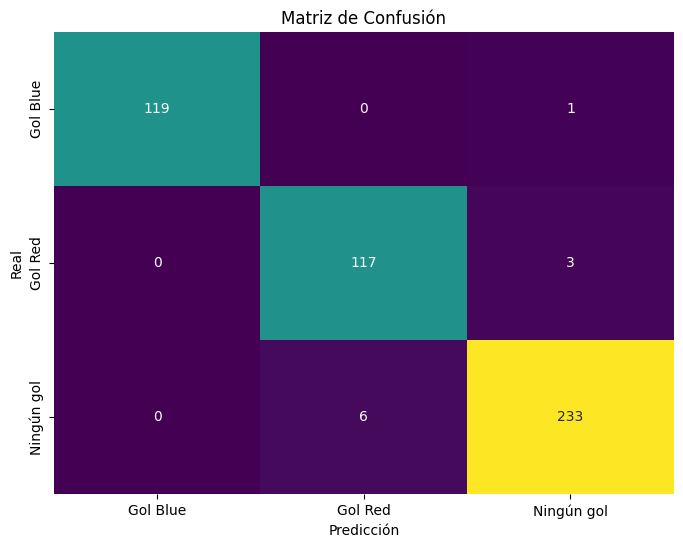

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'],
            yticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

#### Para 6 ticks

##### Modelo principal

In [49]:
data_posiciones_grouped_filtered_labeled['gol_6_ticks'].value_counts()

gol_6_ticks
none    8294
Red      685
Blue     594
Name: count, dtype: int64

In [50]:
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Creación de la clave combinada
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)

# Separación de clases para balanceo
indices_nada = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_6_ticks'] == 'none'].index
indices_gol_rojo = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_6_ticks'] == 'Red'].index
indices_gol_azul = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_6_ticks'] == 'Blue'].index

# Determinar la cantidad a muestrear para balancear
n = 2 # proporcion de None vs Red(Blue)
num_muestras_gol = min(len(indices_gol_rojo), len(indices_gol_azul), len(indices_nada)/n)
num_muestras_nada = num_muestras_gol * n

# Muestreo balanceado de combinaciones match_time
indices_nada_balanceados = resample(indices_nada, n_samples=num_muestras_nada, replace=False, random_state=random_state)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, n_samples=num_muestras_gol, replace=False, random_state=random_state)
indices_gol_azul_balanceados = resample(indices_gol_azul, n_samples=num_muestras_gol, replace=False, random_state=random_state)

print('indices nada balanceados:', indices_nada_balanceados, len(indices_nada_balanceados))
print('indices gol rojo balanceados:', indices_gol_rojo_balanceados, len(indices_gol_rojo_balanceados))
print('indices gol azul balanceados:', indices_gol_azul_balanceados, len(indices_gol_azul_balanceados))

print(data_posiciones_filtered.sample(7))

indices nada balanceados: Index([7711, 5468, 4733, 9370, 8827, 6321, 1966, 7733, 1224,  440,
       ...
       2571, 4279, 7047, 4037, 5115, 5855, 3316, 5959, 6937, 5356],
      dtype='int64', length=1188) 1188
indices gol rojo balanceados: Index([3154, 3599, 4874, 6112, 8086, 3812, 5801, 1880, 2890, 1878,
       ...
       6654, 6530, 7074, 1590, 7347, 1331, 5442, 8847, 4877, 5797],
      dtype='int64', length=594) 594
indices gol azul balanceados: Index([9452, 1082, 3989, 4293, 8548, 4077, 3877, 7568, 1658, 7465,
       ...
       9469, 9190, 3486,  481, 6600, 6596, 7353, 2734, 3878, 2860],
      dtype='int64', length=594) 594
          id  match_id  player_id         x         y  velocity_x  velocity_y  \
7233   29927        50         54  0.507954  0.043508    0.156435    0.621919   
45314  75307       111        115  0.766167  0.891714    0.204722    0.642569   
40329  69010       101        105  0.498273  0.389932    0.213076    0.619964   
27050  51802        79         48  0.27

In [51]:
# Combinar los índices balanceados
indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])
rng  = np.random.default_rng(random_state)
rng.shuffle(indices_balanceados)

print(indices_balanceados)

# Seleccionar los datos balanceados
data_balanceada = data_posiciones_grouped_filtered_labeled.loc[indices_balanceados]
print(data_balanceada)

[5646 4596 4291 ... 8001 1224 3210]
      match_id        time  entities gol_1_ticks gol_2_ticks gol_3_ticks  \
5646       101   22.733333         7        none        none        none   
4596        92  188.033333         7        none        none        none   
4291        90    4.316667         7        none        none        none   
7406       123   51.466667         7        none        none        none   
753         48   12.316667         7        none        none        none   
3213        75   65.083333         7        none        none         Red   
2979        73   23.133333         7        none        none        none   
3252        75  104.083333         7        none        Blue        Blue   
8290       130  123.233333         7        none        none        none   
4321        90   34.316667         7        none        none        none   
7423       123   68.466667         7        none        none        none   
6606       115   73.183333         7        none    

In [52]:
# Construir los vectores de características (X) y etiquetas (y)
X = []
y = []

for row in data_balanceada.itertuples():
    match_time = row.match_time
    gol_6_ticks = row.gol_6_ticks
    
    # Seleccionar las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    if len(subset) == 7:  # Asegurarse de tener las 7 filas
        input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
        X.append(input_data)
        y.append(gol_6_ticks)
    else:
        print(f"Advertencia: {match_time} no tiene 7 filas.")

X = np.array(X)
y = np.array(y)

In [53]:
print(X[0:2])
print(y)
from collections import Counter
print("Distribución balanceada de clases:", Counter(y))

[[ 0.64306161  0.32606857  0.19583569  0.70416052  1.          0.8284532
   0.27206493  0.17227174  0.69490397  1.          0.66839774  0.67417883
   0.19749895  0.67638564  1.          0.64627488  0.45870766  0.19848655
   0.67242536 -1.          0.83805162  0.18222714  0.18721788  0.6855092
  -1.          0.44154924  0.4220735   0.19144045  0.64950012 -1.
   0.74688819  0.29680664  0.1577765   0.73986449  0.        ]
 [ 0.62788281  0.33912464  0.18399827  0.61623924 -1.          0.45394083
   0.20606826  0.16340025  0.53571563 -1.          0.36432904  0.61043686
   0.17041612  0.54091715 -1.          0.47344013  0.40986199  0.17577702
   0.54233544  1.          0.84320374  0.39182844  0.18314488  0.5508981
   1.          0.5739301   0.52958697  0.18147795  0.52973217  1.
   0.45279472  0.24801701  0.18739946  0.38772946  0.        ]]
['none' 'none' 'none' ... 'none' 'none' 'Red']
Distribución balanceada de clases: Counter({'none': 1188, 'Red': 594, 'Blue': 594})


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y) # stratify=y hace que se mantenga las proporciones

In [55]:
print(Counter(y_train))
print(Counter(y_test))

Counter({'none': 831, 'Red': 416, 'Blue': 416})
Counter({'none': 357, 'Blue': 178, 'Red': 178})


In [56]:
# Crear el modelo
from sklearn.neural_network import MLPClassifier
modelo = MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 64), learning_rate_init=0.001, activation='relu', solver='adam', max_iter=500, random_state=random_state)

# Entrenar el modelo
modelo.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=500,
              random_state=900438094)

Counter({'none': 351, 'Red': 184, 'Blue': 178})
              precision    recall  f1-score   support

    Gol Blue       0.82      0.82      0.82       178
     Gol Red       0.66      0.68      0.67       178
  Ningún gol       0.78      0.76      0.77       357

    accuracy                           0.76       713
   macro avg       0.75      0.75      0.75       713
weighted avg       0.76      0.76      0.76       713



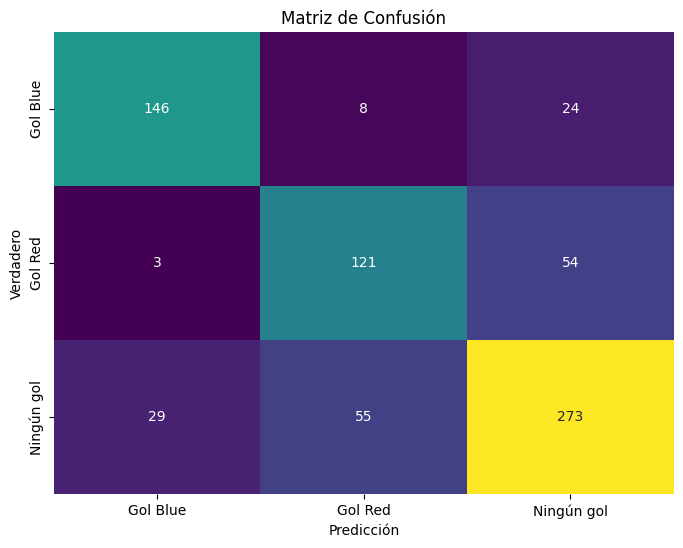

In [57]:
# Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = modelo.predict(X_test)
print(Counter(y_pred))
print(classification_report(y_test, y_pred, target_names=['Gol Blue', 'Gol Red', 'Ningún gol']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'],
            yticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [58]:
# Obtener las probabilidades de las predicciones en el conjunto de prueba
probabilidades = modelo.predict_proba(X_test)

# Convertir las probabilidades a un DataFrame
probabilidades_df = pd.DataFrame(probabilidades, columns=['%Blue', '%Red', '%None'])
probabilidades_df = probabilidades_df.round(5)

# Agregar las columnas de valor real
probabilidades_df['Valor real'] = y_test

# Reorganizar las columnas
probabilidades_df = probabilidades_df[['Valor real', '%Blue', '%Red', '%None']]

# Mostrar todas las filas (en Jupyter Notebook, muestra todas)
pd.set_option('display.max_rows', None)
print(probabilidades_df)

    Valor real    %Blue     %Red    %None
0         none  0.00000  0.52464  0.47535
1         Blue  0.89521  0.00000  0.10479
2         Blue  0.99029  0.00000  0.00971
3          Red  0.00298  0.62043  0.37659
4         none  0.99031  0.00014  0.00955
5         Blue  0.99983  0.00000  0.00017
6         none  0.09081  0.00562  0.90357
7         Blue  0.00297  0.00001  0.99702
8         none  0.00001  0.08275  0.91724
9         none  0.00000  0.00000  1.00000
10         Red  0.00179  0.08741  0.91080
11        Blue  0.96964  0.00000  0.03036
12        Blue  0.53291  0.02243  0.44466
13        none  0.00000  0.39673  0.60326
14         Red  0.00010  0.98725  0.01265
15        Blue  0.99964  0.00000  0.00036
16        none  0.00000  0.00000  1.00000
17         Red  0.00000  0.89383  0.10617
18        none  0.00000  0.00015  0.99985
19        none  0.00161  0.00001  0.99838
20        none  0.00092  0.00009  0.99899
21         Red  0.00435  0.00260  0.99306
22        none  0.00001  0.00507  

In [59]:
probabilidades_df_sample_15 = probabilidades_df.sample(10, random_state=random_state).reset_index()
print(probabilidades_df_sample_15)

   index Valor real    %Blue     %Red    %None
0    647       none  0.00004  0.66702  0.33294
1    376        Red  0.00000  0.99997  0.00003
2    313       none  0.00000  0.45715  0.54285
3    132       none  0.00000  0.10057  0.89942
4    712       none  0.35512  0.00018  0.64470
5    565       Blue  0.02120  0.00007  0.97872
6    525       none  0.66933  0.00439  0.32629
7    463       none  0.00010  0.00659  0.99331
8    316       none  0.00000  0.00010  0.99990
9    278        Red  0.00000  0.99501  0.00499


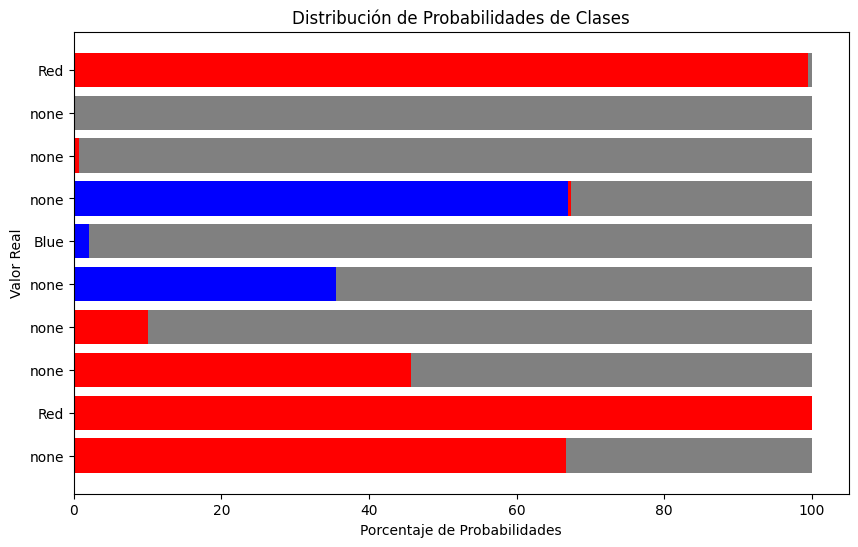

In [60]:
# Crear gráfico de barras apiladas horizontal
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras apiladas para cada fila
for i, row in probabilidades_df_sample_15.iterrows():
    ax.barh(i, row['%Blue']*100, color='blue')
    ax.barh(i, row['%Red']*100, left=row['%Blue']*100, color='red')
    ax.barh(i, row['%None']*100, left=(row['%Blue'] + row['%Red'])*100, color='gray')

# Etiquetas y título
ax.set_xlabel('Porcentaje de Probabilidades')
ax.set_ylabel('Valor Real')
ax.set_title('Distribución de Probabilidades de Clases')



# Asignar las etiquetas del eje Y con los valores de la columna 'Valor real'
ax.set_yticks(range(len(probabilidades_df_sample_15)))
ax.set_yticklabels(probabilidades_df_sample_15['Valor real'].values)

# Mostrar el gráfico
plt.show()

#### Para 1 ticks

##### Modelo principal

In [62]:
data_posiciones_grouped_filtered_labeled['gol_1_ticks'].value_counts()

gol_1_ticks
none    9358
Red      116
Blue      99
Name: count, dtype: int64

In [63]:
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Creación de la clave combinada
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)

# Separación de clases para balanceo
indices_nada = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_1_ticks'] == 'none'].index
indices_gol_rojo = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_1_ticks'] == 'Red'].index
indices_gol_azul = data_posiciones_grouped_filtered_labeled[data_posiciones_grouped_filtered_labeled['gol_1_ticks'] == 'Blue'].index

# Determinar la cantidad a muestrear para balancear
n = 2 # proporcion de None vs Red(Blue)
num_muestras_gol = min(len(indices_gol_rojo), len(indices_gol_azul), len(indices_nada)/n)
num_muestras_nada = num_muestras_gol * n

# Muestreo balanceado de combinaciones match_time
indices_nada_balanceados = resample(indices_nada, n_samples=num_muestras_nada, replace=False, random_state=random_state)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, n_samples=num_muestras_gol, replace=False, random_state=random_state)
indices_gol_azul_balanceados = resample(indices_gol_azul, n_samples=num_muestras_gol, replace=False, random_state=random_state)

print('indices nada balanceados:', indices_nada_balanceados, len(indices_nada_balanceados))
print('indices gol rojo balanceados:', indices_gol_rojo_balanceados, len(indices_gol_rojo_balanceados))
print('indices gol azul balanceados:', indices_gol_azul_balanceados, len(indices_gol_azul_balanceados))

print(data_posiciones_filtered.sample(7))

indices nada balanceados: Index([4849, 6812, 8037, 5654, 1954, 4474, 5634, 5096, 1961,  849,
       ...
       8435, 6614, 9042, 1262, 7236, 3234, 2460, 7016, 2080, 4590],
      dtype='int64', length=198) 198
indices gol rojo balanceados: Index([4804, 6027, 6369, 8395, 8852, 8072, 2109, 4288, 1874, 2439, 1816, 7788,
       9388, 6024, 7762, 3836, 5542,  256, 6112, 1703, 4189, 2570, 4986, 4286,
       5134, 2171, 8533, 6473, 4407, 1596, 8468, 4878, 5762, 7509, 2493, 3813,
       9420, 4547, 3820, 1093, 7348, 4974, 9355, 8642, 3408, 1880, 1982, 1826,
       3215,   33,  915, 8295, 6098, 2155, 3633, 5432, 2027, 1550, 7681, 2273,
       5994, 3600, 2895, 6903, 1566, 3155, 2524, 2579, 3426, 6398, 4091, 9267,
       1133, 1062, 5444, 1832,  284, 5329, 5802, 9016, 7796, 6301, 8087, 6765,
       7272, 8203, 3147, 6659, 8325, 9269, 1459, 5519, 6529, 5212, 8898,   61,
       1594, 1336, 7753],
      dtype='int64') 99
indices gol azul balanceados: Index([8043, 1440, 3891, 4297, 5139, 7882, 3926, 

In [64]:
# Combinar los índices balanceados
indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])
rng  = np.random.default_rng(random_state)
rng.shuffle(indices_balanceados)

print(indices_balanceados)

# Seleccionar los datos balanceados
data_balanceada = data_posiciones_grouped_filtered_labeled.loc[indices_balanceados]
print(data_balanceada)

[1527 3879  794 8696 6581 2109 4870 8539 7971 7926 6291 6301 7722 8423
 7570 2598  557 4511  830 1085 9537 3820 9229  868 7925 2441 4974  307
 8395 4081   33  456 3813 7727 8223 4740 2923 4111 9076 9010 2273 5255
 7509 9458 4878 1874 7990 5282 9420  617 2865 5738 7610 6279 8468 7448
 5542 9388 3234   57 6832 9572 2908 5432 1703  155 8533  985 8243 1375
 5844 8510 7391 9016  256 5096 2584 9194 5134 8295 2610  470 8642 8428
 6659 2531 4065 5994 4286 3182  587 9378 6801   17 1954 1880 9355 3641
 8553 4590 4837 9011 6300 7753 8831 2384 8203 6903 2395  305 1282 6369
 4200 1683 5345 6127 9042  637 1826  915 7917 2282 3976 4473  665 4904
  284 1101  994 2557 4091 7856 4189 5802 6112 6503 9269 3674 6751 8898
 8797 6502 5634 8043 2884 3147 7016 3408 9259 7033 1133  668 6294 6027
 2927 3991 9523 6785 8325 6098 6614 5829 6024 5779 6376 2027 2386  321
 1735 2684 5532  849 6473 4772 7892 8058 5152  380 3155 5757 1550 1427
 4288 4020 8563 3748 1596 5720 4838 7354 9267 2493   61 2080 4474 9426
 6044 

In [65]:
# Construir los vectores de características (X) y etiquetas (y)
X = []
y = []

for row in data_balanceada.itertuples():
    match_time = row.match_time
    gol_1_ticks = row.gol_1_ticks
    
    # Seleccionar las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    if len(subset) == 7:  # Asegurarse de tener las 7 filas
        input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
        X.append(input_data)
        y.append(gol_1_ticks)
    else:
        print(f"Advertencia: {match_time} no tiene 7 filas.")

X = np.array(X)
y = np.array(y)

In [66]:
print(X[0:2])
print(y)
from collections import Counter
print("Distribución balanceada de clases:", Counter(y))

[[ 0.57622972  0.90328604  0.18399353  0.62584827  1.          0.13949186
   0.36820637  0.19313526  0.68399216  1.          0.30504513  0.51161445
   0.1611141   0.68483912  1.          0.67642865  0.59916789  0.18399385
   0.62584773 -1.          0.71252373  0.82408705  0.18399388  0.62584768
  -1.          0.76884497  0.42940449  0.18399402  0.6258468  -1.
   0.12570869  0.39402766  0.17765794  0.66231463  0.        ]
 [ 0.30218285  0.53244073  0.16871499  0.68170041  1.          0.53797851
   0.5517252   0.17335534  0.63772779  1.          0.16975511  0.62598996
   0.1653735   0.64456953  1.          0.15170467  0.66631588  0.15615333
   0.62039482 -1.          0.29107422  0.23043336  0.1620533   0.63733944
  -1.          0.45794301  0.62308772  0.16345628  0.70761151 -1.
   0.1907461   0.4944095   0.14190862  0.64347362  0.        ]]
['Blue' 'Blue' 'Blue' 'none' 'Blue' 'Red' 'none' 'Blue' 'none' 'Blue'
 'none' 'Red' 'Blue' 'Blue' 'none' 'Blue' 'Blue' 'none' 'none' 'Blue'
 'none' '

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y) # stratify=y hace que se mantenga las proporciones

In [80]:
print(Counter(y_train))
print(Counter(y_test))

Counter({'none': 139, 'Blue': 69, 'Red': 69})
Counter({'none': 59, 'Blue': 30, 'Red': 30})


In [81]:
# Crear el modelo
from sklearn.neural_network import MLPClassifier
modelo = MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 64), learning_rate_init=0.001, activation='relu', solver='adam', max_iter=500, random_state=random_state)

# Entrenar el modelo
modelo.fit(X_train, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(256, 128, 64), max_iter=500,
              random_state=900438094)

Counter({'none': 64, 'Blue': 37, 'Red': 18})
              precision    recall  f1-score   support

    Gol Blue       0.59      0.73      0.66        30
     Gol Red       0.67      0.40      0.50        30
  Ningún gol       0.59      0.64      0.62        59

    accuracy                           0.61       119
   macro avg       0.62      0.59      0.59       119
weighted avg       0.61      0.61      0.60       119



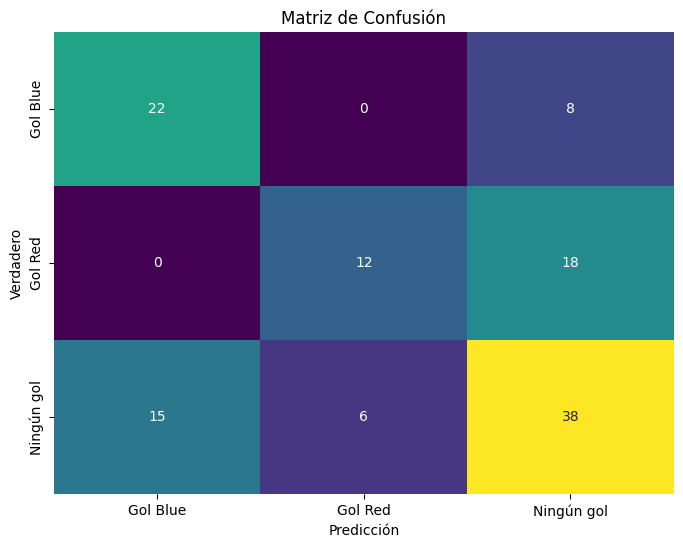

In [82]:
# Evaluación del modelo
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = modelo.predict(X_test)
print(Counter(y_pred))
print(classification_report(y_test, y_pred, target_names=['Gol Blue', 'Gol Red', 'Ningún gol']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'],
            yticklabels=['Gol Blue', 'Gol Red', 'Ningún gol'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

In [83]:
# Obtener las probabilidades de las predicciones en el conjunto de prueba
probabilidades = modelo.predict_proba(X_test)

# Convertir las probabilidades a un DataFrame
probabilidades_df = pd.DataFrame(probabilidades, columns=['%Blue', '%Red', '%None'])
probabilidades_df = probabilidades_df.round(5)

# Agregar las columnas de valor real
probabilidades_df['Valor real'] = y_test

# Reorganizar las columnas
probabilidades_df = probabilidades_df[['Valor real', '%Blue', '%Red', '%None']]

# Mostrar todas las filas (en Jupyter Notebook, muestra todas)
pd.set_option('display.max_rows', None)
print(probabilidades_df)

    Valor real    %Blue     %Red    %None
0         none  0.00797  0.00000  0.99203
1         Blue  0.00217  0.00000  0.99783
2         Blue  0.99951  0.00000  0.00049
3         Blue  0.47943  0.00000  0.52057
4         none  0.00000  0.05019  0.94981
5         Blue  0.99993  0.00000  0.00007
6         none  0.00838  0.00000  0.99162
7          Red  0.00000  0.01640  0.98360
8         none  0.00005  0.00017  0.99978
9         none  0.00061  0.61408  0.38530
10        Blue  0.99987  0.00000  0.00013
11        none  0.13676  0.00000  0.86324
12        none  0.00000  0.99465  0.00535
13        Blue  0.10346  0.00000  0.89654
14        none  0.00013  0.00000  0.99987
15        none  0.94639  0.00000  0.05361
16        Blue  0.99963  0.00000  0.00037
17         Red  0.00000  0.89059  0.10941
18        none  0.00000  0.00638  0.99362
19        Blue  0.98573  0.00000  0.01427
20         Red  0.00000  0.08874  0.91126
21         Red  0.00000  0.02991  0.97009
22         Red  0.00000  0.00106  

In [84]:
probabilidades_df_sample_15 = probabilidades_df.sample(10, random_state=random_state).reset_index()
print(probabilidades_df_sample_15)

   index Valor real    %Blue     %Red    %None
0     55       Blue  0.73378  0.00000  0.26622
1     75        Red  0.00000  0.99999  0.00001
2     79       none  0.00000  0.94463  0.05537
3    101        Red  0.00000  0.00040  0.99960
4     73        Red  0.00000  0.00012  0.99988
5     96        Red  0.00000  0.10647  0.89353
6     24       Blue  0.99958  0.00000  0.00042
7     51       none  0.89229  0.00000  0.10771
8     20        Red  0.00000  0.08874  0.91126
9     29       none  0.93453  0.00000  0.06547


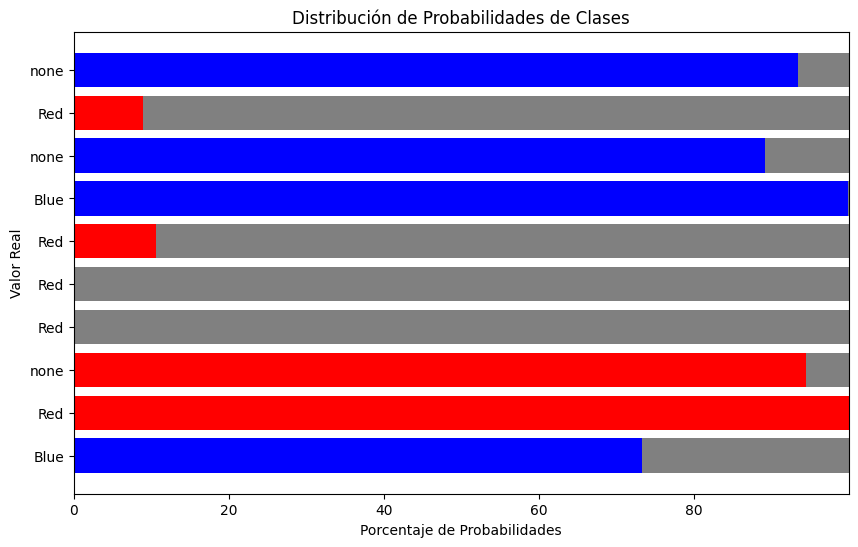

In [85]:
# Crear gráfico de barras apiladas horizontal
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras apiladas para cada fila
for i, row in probabilidades_df_sample_15.iterrows():
    ax.barh(i, row['%Blue']*100, color='blue')
    ax.barh(i, row['%Red']*100, left=row['%Blue']*100, color='red')
    ax.barh(i, row['%None']*100, left=(row['%Blue'] + row['%Red'])*100, color='gray')

# Etiquetas y título
ax.set_xlabel('Porcentaje de Probabilidades')
ax.set_ylabel('Valor Real')
ax.set_title('Distribución de Probabilidades de Clases')



# Asignar las etiquetas del eje Y con los valores de la columna 'Valor real'
ax.set_yticks(range(len(probabilidades_df_sample_15)))
ax.set_yticklabels(probabilidades_df_sample_15['Valor real'].values)

# Mostrar el gráfico
plt.show()

#### No funciona:

In [ ]:
#NO FUNCIONA ESTO

import pydot_ng as pydot

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

# Crear el modelo con Keras
model_keras = Sequential()
model_keras.add(Dense(128, input_dim=4, activation='relu'))
model_keras.add(Dense(64, activation='relu'))
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(3, activation='softmax'))  # Tres clases de salida (para el Iris dataset)

# Compilar el modelo
model_keras.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Visualizar la arquitectura
plot_model(model_keras, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Mostrar el gráfico
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
def get_features_for_match_time(match_id, time, data_pos):
    subset = data_pos[(data_pos['match_id'] == match_id) & (data_pos['time'] == time)]
    red_players = subset[subset['team'] == -1][['x', 'y', 'velocity_x', 'velocity_y']].values
    blue_players = subset[subset['team'] == 1][['x', 'y', 'velocity_x', 'velocity_y']].values
    ball = subset[subset['player_id'] == 0][['x', 'y', 'velocity_x', 'velocity_y']].values  # Suponer que la pelota tiene un id específico
    # Ordenar aleatoriamente para asegurar independencia del orden de jugadores
    np.random.shuffle(red_players)
    np.random.shuffle(blue_players)
    return np.concatenate([red_players.flatten(), blue_players.flatten(), ball.flatten()])

In [ ]:
# Combinar los IDs para facilitar la búsqueda
data_posiciones_grouped_filtered_labeled['match_time'] = data_posiciones_grouped_filtered_labeled['match_id'].astype(str) + '_' + data_posiciones_grouped_filtered_labeled['time'].astype(str)
data_posiciones_filtered['match_time'] = data_posiciones_filtered['match_id'].astype(str) + '_' + data_posiciones_filtered['time'].astype(str)


In [ ]:
# Crear una lista de arrays con las posiciones y velocidades para cada match_time
X = []
y = []

print(data_posiciones_grouped_filtered_labeled)

for row in data_posiciones_grouped_filtered_labeled.itertuples():
    match_time = row.match_time
    gol_3_ticks = row.gol_3_ticks  # Etiqueta objetivo
    
    # Selecciona las 7 filas correspondientes
    subset = data_posiciones_filtered[data_posiciones_filtered['match_time'] == match_time]
    input_data = subset[['x', 'y', 'velocity_x', 'velocity_y', 'team']].values.flatten()
    
    X.append(input_data)
    y.append(gol_3_ticks)

X = np.array(X)
y = np.array(y)


In [ ]:
print(X_train[0])
#print(y)

In [ ]:
# Separo las clases
indices_nada = np.where(y == 'none')[0]  # Clase 'sin gol'
indices_gol_rojo = np.where(y == 'Red')[0]  # Clase 'gol del Red'
indices_gol_azul = np.where(y == 'Blue')[0]  # Clase 'gol del Blue'

#print(indices_nada)
#print(indices_gol_rojo)
#print(indices_gol_azul)

# Balanceo las clases y muestreo
from sklearn.utils import resample

# Proporcion 50% nada, 25% gol del Red, 25% gol del Blue
num_muestras_gol = round(min(len(indices_gol_rojo), len(indices_gol_azul))/5)
num_muestras_nada = num_muestras_gol * 2

indices_nada_balanceados = resample(indices_nada, replace=False, n_samples=num_muestras_nada, random_state=8493278)
indices_gol_rojo_balanceados = resample(indices_gol_rojo, replace=False, n_samples=num_muestras_gol, random_state=8493278)
indices_gol_azul_balanceados = resample(indices_gol_azul, replace=False, n_samples=num_muestras_gol, random_state=8493278)

indices_balanceados = np.concatenate([indices_nada_balanceados, indices_gol_rojo_balanceados, indices_gol_azul_balanceados])

from sklearn.utils import shuffle
X_balanceado = X[indices_balanceados]
y_balanceado = y[indices_balanceados]
X_balanceado, y_balanceado = shuffle(X_balanceado, y_balanceado, random_state=8493278)

In [ ]:
print(X_balanceado)
print(y_balanceado)

In [ ]:
from collections import Counter
print(Counter(y_balanceado))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado, test_size=0.3, random_state=8493278)

# Crear el modelo
modelo = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', max_iter=500)

# Entrenar el modelo
modelo.fit(X_train, y_train)


In [ ]:
print(X_train[0])
print(y)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
print(confusion_matrix(y_test, y_pred))


In [ ]:
# Predicciones
y_pred = modelo.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'],
            yticklabels=['Ningún gol', 'Gol rojo', 'Gol azul'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# Explicación de la matriz
tabla_explicacion = {
    'Filas (Verdadero)': ['Ningún gol', 'Gol rojo', 'Gol azul'],
    'Columnas (Predicción)': ['Ningún gol', 'Gol rojo', 'Gol azul']
}
print("\nExplicación de la matriz de confusión:")
for i, fila in enumerate(tabla_explicacion['Filas (Verdadero)']):
    print(f"Fila {i}: {fila} (Verdadero)")
    print(f" - Columna 0: Predicho como {tabla_explicacion['Columnas (Predicción)'][0]}")
    print(f" - Columna 1: Predicho como {tabla_explicacion['Columnas (Predicción)'][1]}")
    print(f" - Columna 2: Predicho como {tabla_explicacion['Columnas (Predicción)'][2]}")

In [ ]:
ejemplo_crudo_test1 = [
-92.56451288707532,	124.45015137068071,	159.4897871523994,	12.686438615544656,	1,
-46.86904236747758,	-82.09417184724326,	162.2066739689642,	3.8808615266944106,	1,
-1.0282322976049685,	-158.42819156230084,138.42971007348893,	20.278973949055498,	1,
-15.400174216859035,	-132.0779034978056,	106.8216737279782,	-14.19809709458249,	2,
369.8938602877177,	-34.44229930738148, 112.5701383585176,	-0.46031655316848,	2,
14.03888309503283,	-126.30365856126663, 123.08482179344048,	-36.63696694933308,	1,
33.03107592831144,	-135.74791243559724,	92.00083312965478,	68.79246629432616,	0
]

columns = ['x', 'y', 'velocity_x', 'velocity_y', 'team']
data_test1 = pd.DataFrame([ejemplo_crudo_test1[i:i + 5] for i in range(0, len(ejemplo_crudo_test1), 5)], columns=columns)

data_test1_normalizada = normalizar_datos(data_test1)
print(data_test1_normalizada)

### ...etc... (no correr)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Definir el modelo
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Salida para 3 clases: ninguno, gol rojo, gol azul
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Entrenar el modelo
history = model.fit(X, y.argmax(axis=1), epochs=50, batch_size=32, validation_split=0.2)


In [ ]:
loss, accuracy = model.evaluate(X, y.argmax(axis=1))
print(f"Loss: {loss}, Accuracy: {accuracy}")


In [ ]:
# Predecir probabilidades para cada entrada
predicciones_probabilidades = model.predict(X)

# Convertir las probabilidades en clases (0, 1, 2)
predicciones_clases = predicciones_probabilidades.argmax(axis=1)


In [ ]:
import pandas as pd

# Crear un DataFrame para analizar
resultados = pd.DataFrame({
    'match_id': data_posiciones_grouped_filtered_labeled['match_id'],
    'time': data_posiciones_grouped_filtered_labeled['time'],
    'prediccion_clase': predicciones_clases,
    'gol_verdadero': y.argmax(axis=1),  # Convertir las etiquetas verdaderas en la misma forma
    'prob_nada': predicciones_probabilidades[:, 0],
    'prob_gol_rojo': predicciones_probabilidades[:, 1],
    'prob_gol_azul': predicciones_probabilidades[:, 2],
})

# Mostrar los primeros resultados
print(resultados.sample(10))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar un informe de clasificación
print(classification_report(y.argmax(axis=1), predicciones_clases, target_names=['Ningún gol', 'Gol rojo', 'Gol azul']))

# Matriz de confusión
print(confusion_matrix(y.argmax(axis=1), predicciones_clases))
